In [1]:
] activate ..

In [2]:
const IsingTc = 1/(1/2*log(1+sqrt(2)))

2.269185314213022

In [3]:
const SpinType = Int8

Int8

In [4]:
using ProgressMeter, Distributions, DataFrames, Plots, StatsPlots, HDF5, JLD2
using Dates, Printf, Statistics

In [5]:
struct MonteCarlo
    L::Int
    N::Int
    neighs::Matrix{Int} # row = up, right, down, left neighbors; col = linear siteidx
    conf::Matrix{SpinType}
    beta::Float64 # inverse temperature
    nsweeps::Int
    measure_rate::Int
end

function MonteCarlo(; L, T, nsweeps=10^7, measure_rate = 5_000)
    lattice = reshape(1:L^2, (L, L))
    up     = circshift(lattice, (-1,0))
    right  = circshift(lattice, (0,-1))
    down   = circshift(lattice,(1,0))
    left   = circshift(lattice,(0,1))
    neighs = vcat(up[:]',right[:]',down[:]',left[:]')
    
    conf = rand(SpinType[-1, 1], L, L)
    beta = 1/T
    
    MonteCarlo(L, L^2, neighs, conf, beta, nsweeps, measure_rate)
end

MonteCarlo

In [6]:
eachsite(mc::MonteCarlo) = 1:mc.N
neighbors(mc::MonteCarlo, i::Integer) = mc.neighs[1,i], mc.neighs[2,i], mc.neighs[3,i], mc.neighs[4,i]

neighbors (generic function with 1 method)

In [7]:
function energy(mc::MonteCarlo)
    E = 0.0
    @inbounds @simd for i in eachsite(mc)
        E -= mc.conf[i]*mc.conf[mc.neighs[1,i]] + mc.conf[i]*mc.conf[mc.neighs[2,i]]
    end
    E
end

energy (generic function with 1 method)

In [8]:
function run!(mc::MonteCarlo)
    nmeas = floor(Int, mc.nsweeps / mc.measure_rate)
    imeas = 1
    
    m     = Vector{Float64}(undef, nmeas)
    m2    = Vector{Float64}(undef, nmeas)
    confs = Vector{Matrix{SpinType}}(undef, nmeas)
    
    start_time = now()
    println("Started: ", Dates.format(start_time, "d.u yyyy HH:MM"))
    
    for i in 1:mc.nsweeps # @showprogress 3 
        
        # sweep
        for i in eachindex(mc.conf)
            # local update
            up, right, down, left = neighbors(mc, i)
            ΔE = 2.0 * mc.conf[i] * (mc.conf[up] + mc.conf[right] + mc.conf[down] + mc.conf[left])
            
            # Metropolis
            if ΔE <= 0 || rand() < exp(- mc.beta*ΔE)
                mc.conf[i] *= -1 # flip spin
            end
        end
        
        # measure
        if iszero(mod(i, mc.measure_rate))
            m[imeas]     = abs(sum(mc.conf))
            m2[imeas]    = m[imeas]*m[imeas]
            confs[imeas] = copy(mc.conf)
            imeas += 1
        end
    end
    
    chi = mc.beta*(mean(m2)/mc.N - mean(m)*mean(m)/mc.N)
    m ./= mc.N
    
    end_time = now()
    println("Ended: ", Dates.format(end_time, "d.u yyyy HH:MM"))
    @printf("Duration: %.2f minutes", (end_time - start_time).value / 1000. /60.)
    
    return confs, m, chi
end

run! (generic function with 1 method)

In [105]:
mc = MonteCarlo(L = 8, T = 0.1)

MonteCarlo(8, 64, [2 3 … 64 57; 9 10 … 7 8; 8 1 … 62 63; 57 58 … 55 56], Int8[-1 1 … 1 1; 1 -1 … 1 1; … ; -1 1 … 1 -1; -1 -1 … 1 1], 10.0, 10000000, 5000)

In [58]:
confs, m, chi = run!(mc);

Started: 22.Jun 2019 09:03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


 20.131946 seconds (10.09 M allocations: 767.700 MiB, 0.23% gc time)


In [59]:
confs[end]

8×8 Array{Int8,2}:
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1

In [80]:
mean(m), chi

(1.0, 0.0)

# Simulate multiple $T$s and $L$s

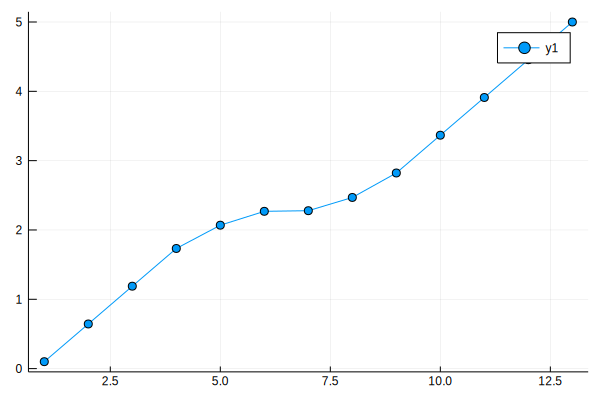

In [9]:
Tdist = Normal(IsingTc, .64)
Ts = sort!(rand(Tdist, 10))
Ts = Ts[Ts.>=1.2]
Ts = Ts[Ts.<=3.8]

Ts = range(0.1, 5, length=10) |> collect
push!(Ts, IsingTc)
push!(Ts, IsingTc+0.2)
push!(Ts, IsingTc-0.2)
push!(Ts, 0.1)
push!(Ts, 5)
Ts = unique(round.(Ts, digits=3))
sort!(Ts)
plot(Ts, marker=:circle)

In [10]:
function save_confs_to_disk(filename, L, T, confs; overwrite = true)
    dset = "L$(L)/T$(T)/confs"
    h5open(filename, isfile(filename) ? "r+" : "w") do f
        has(f, dset) && overwrite && o_delete(f, dset)
        f[dset] = cat(confs..., dims=3)
    end
    nothing
end

save_confs_to_disk (generic function with 1 method)

In [11]:
df = DataFrame(L=Int[], T=Float64[], M=Float64[], χ=Float64[])

for L in [8, 16, 32, 64] #2 .^ [3, 4, 5, 6]
    println("L = ", L)
    
    for (i, T) in enumerate(Ts)
        println("\n\t T = ", T, "\n"); flush(stdout);
        
        mc = MonteCarlo(L = L, T = T)
        confs, m, chi = run!(mc);
        push!(df, [L, T, mean(m), chi])
        save_confs_to_disk("Ising.h5", L, T, confs)

        println()
    end
end

sort!(df, [:L, :T])
@save "df.jld2" df

println("Done!")

L = 8

	 T = 0.1

Started: 22.Jun 2019 21:23
Ended: 22.Jun 2019 21:23
Duration: 0.29 minutes

	 T = 0.644

Started: 22.Jun 2019 21:23
Ended: 22.Jun 2019 21:23
Duration: 0.30 minutes

	 T = 1.189

Started: 22.Jun 2019 21:23
Ended: 22.Jun 2019 21:24
Duration: 0.30 minutes

	 T = 1.733

Started: 22.Jun 2019 21:24
Ended: 22.Jun 2019 21:24
Duration: 0.29 minutes

	 T = 2.069

Started: 22.Jun 2019 21:24
Ended: 22.Jun 2019 21:24
Duration: 0.29 minutes

	 T = 2.269

Started: 22.Jun 2019 21:24
Ended: 22.Jun 2019 21:24
Duration: 0.30 minutes

	 T = 2.278

Started: 22.Jun 2019 21:24
Ended: 22.Jun 2019 21:25
Duration: 0.30 minutes

	 T = 2.469

Started: 22.Jun 2019 21:25
Ended: 22.Jun 2019 21:25
Duration: 0.29 minutes

	 T = 2.822

Started: 22.Jun 2019 21:25
Ended: 22.Jun 2019 21:25
Duration: 0.30 minutes

	 T = 3.367

Started: 22.Jun 2019 21:25
Ended: 22.Jun 2019 21:26
Duration: 0.28 minutes

	 T = 3.911

Started: 22.Jun 2019 21:26
Ended: 22.Jun 2019 21:26
Duration: 0.29 minutes

	 T = 4.456

Sta

# Analysis

In [12]:
@load "df.jld2"

1-element Array{Symbol,1}:
 :df

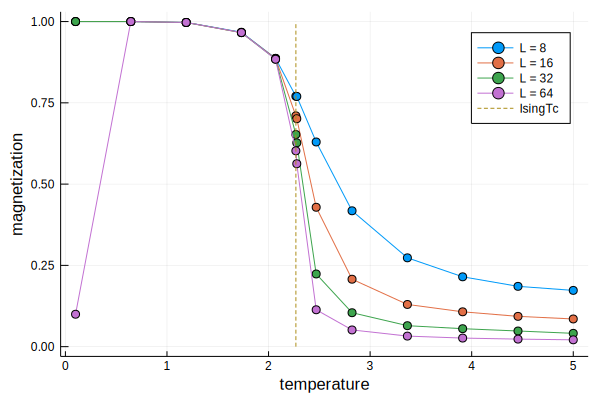

In [13]:
@df df plot(:T, :M, group=(L = :L,), marker=:circle, xlab="temperature", ylab="magnetization")
plot!([IsingTc, IsingTc], [0, 1], ls=:dash, label="IsingTc")

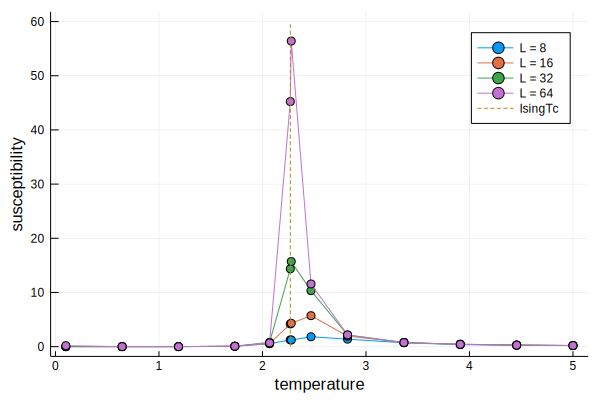

In [14]:
@df df plot(:T, :χ, group=(L = :L,), marker=:circle, xlab="temperature", ylab="susceptibility")
plot!([IsingTc, IsingTc], [0, 60], ls=:dash, label="IsingTc")